In [1]:
CONFIG_PATH = "configs/small_sample_sub_no_peer.yml"

In [2]:
from collections import Counter, defaultdict
import os
import random
import shutil
import numpy as np
import pandas as pd
from superdebug import debug
import torch
from process_data import get_model_input
from utils import get_config, join_sets, load_model, print_log, save_model, load_model_dict
from model import get_best_model
from venn import venn, pseudovenn

为了使用邮件提醒功能，请设置环境变量MY_QQ_EMAIL（QQ邮箱地址）与MY_QQ_EMAIL_PWD（QQ邮箱授权码）
------------------ 2022-08-01 18:18:30 ------------------


##### Preprocess

Load model and data

In [40]:
config = get_config(CONFIG_PATH, "_curation", print_config = False)
target, original_feature_map, categorical_features, string_features, train_data, test_data, test_data_info, num_all_users = get_model_input(config)
extra_input = (categorical_features, string_features, target)
model, token_embedding = get_best_model(config, categorical_features, string_features, original_feature_map)
model.eval()
active_user_votes_thres = config["active_user_votes_thres"]
all_users = list(range(num_all_users + 1))

GPU ready...
Smart using cuda:2
------------------ 2022-08-01 18:56:03 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/process_data.py:327 get_model_input
Loading prepared data...
------------------ 2022-08-01 18:56:03 ------------------
------------------ 2022-08-01 18:56:05 ------------------
DEBUG: 1 vars: ['original_token_num'], at /home/TableSense/largedisk/wanrong/Curation-Modeling/model.py:242 get_tokenizer
0 / 26.  original_token_num num val: 30522
------------------ 2022-08-01 18:56:05 ------------------
------------------ 2022-08-01 18:56:06 ------------------
DEBUG: 1 vars: ['latest_token_num'], at /home/TableSense/largedisk/wanrong/Curation-Modeling/model.py:254 get_tokenizer
0 / 27.  latest_token_num num val: 154132
------------------ 2022-08-01 18:56:06 ------------------


Some weights of the model checkpoint at prajjwal1/bert-mini were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


------------------ 2022-08-01 18:56:07 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:110 load_model
Loading best model...
------------------ 2022-08-01 18:56:07 ------------------


Collect submissions and active users in different subreddits

In [4]:
def get_subreddits_submissions(train_data:pd.DataFrame, test_data:pd.DataFrame, user_votes_thres = 0):
    subreddit_votes_counter = Counter()
    subreddit_active_users = defaultdict(Counter)
    subreddit_train_submissions = defaultdict(dict)
    subreddit_test_submissions = defaultdict(dict)
    all_submissions = dict()
    for i, row in train_data.iterrows():
        subreddit_votes_counter[row["SUBREDDIT"]] += 1
        subreddit_active_users[row["SUBREDDIT"]][row["USERNAME"]] += 1
        if row["SUBMISSION_ID"] not in subreddit_train_submissions[row["SUBREDDIT"]]:
            subreddit_train_submissions[row["SUBREDDIT"]][row["SUBMISSION_ID"]] = row
            all_submissions[row["SUBMISSION_ID"]] = row
    for subreddit in subreddit_active_users:
        users_vote_count = subreddit_active_users[subreddit]
        subreddit_active_users[subreddit] = {user for user in users_vote_count if users_vote_count[user] >= user_votes_thres}
    for i, row in test_data.iterrows():
        if row["SUBMISSION_ID"] not in subreddit_test_submissions[row["SUBREDDIT"]]:
            subreddit_test_submissions[row["SUBREDDIT"]][row["SUBMISSION_ID"]] = row
            all_submissions[row["SUBMISSION_ID"]] = row
    return subreddit_votes_counter, subreddit_active_users, subreddit_train_submissions, subreddit_test_submissions, all_submissions
subreddit_votes_counter, subreddit_active_users, subreddit_train_submissions, subreddit_test_submissions, all_submissions = get_subreddits_submissions(train_data, test_data, user_votes_thres = active_user_votes_thres) # subreddit_votes_counter, subreddit_users, subreddit_train_submissions are based on train_data, subreddit_test_submissions are based on test_data

Record down existing votes

So that we can use them to substitute the predicted votes

In [38]:
def record_existing_votes(train_data:pd.DataFrame):
    # collect existing votes
    existing_votes = {}
    existing_user_updown_votes = defaultdict(Counter)
    existing_user_votes = Counter()
    existing_submission_votes = defaultdict(Counter)
    usernames = train_data["USERNAME"].to_list()
    sub_ids = train_data["SUBMISSION_ID"].to_list()
    votes = train_data["VOTE"].to_list()
    for row_i in range(len(train_data)):
        existing_votes[f'{usernames[row_i]}-{sub_ids[row_i]}'] = votes[row_i]
        existing_user_updown_votes[usernames[row_i]][votes[row_i]] += 1
        existing_user_votes[usernames[row_i]] += 1
        existing_submission_votes[sub_ids[row_i]][votes[row_i]] += 1
    return existing_votes, existing_user_votes, existing_user_updown_votes, existing_submission_votes
existing_votes, existing_user_votes, existing_user_updown_votes, existing_submission_votes = record_existing_votes(train_data)


#### Predict votes for all the users on all submissions

Define required functions

In [53]:
from typing import Union
from tqdm import tqdm
from train import evaluate_model
from model import get_tokenizer

def convert_group_users_subreddit_submissions_data(group_users:Union[set,list], unique_submissions:dict):
    group_users_submissions_data = []
    if type(unique_submissions) == dict:
        unique_submissions = pd.DataFrame(list(unique_submissions.values()))

    for user in tqdm(group_users):
        # for submission_id in unique_submissions:
        #     submission:pd.DataFrame = unique_submissions[submission_id].copy(deep=True)
        #     submission["USERNAME"] = user
        #     group_users_submissions_data.append(submission)
        submissions = unique_submissions.copy(deep=True)
        submissions["USERNAME"] = [user] * len(submissions)
        group_users_submissions_data.append(submissions)

    group_users_submissions_data = pd.concat(group_users_submissions_data,axis=0)
    return group_users_submissions_data
def predict_group_users_submissions_votes(model, group_users_submissions_data):
    # predict unseen votes
    return evaluate_model(config, model, data=group_users_submissions_data, weights = None, batch_size=config["batch_size"], sample_voted_users=False, extra_input = extra_input, ret = "prediction") # ndarray size: (3423664, 1)
pred_all_submission_user_vote_score_matrix = None

First convert data to model input

_!!! This process can be time consuming & need more than 200G memory for medium sized dataset, and is not necessary if we use user_embedding to cluster active users_

In [ ]:

all_users_submissions_data = convert_group_users_subreddit_submissions_data(all_users, all_submissions)


Run model to make predictions.

_!!! This process can be time consuming & need more than 200G memory for medium sized dataset, and is not necessary if we use user_embedding to cluster active users_

In [ ]:
model.to(model.device)
predicted_all_users_submissions_votes = predict_group_users_submissions_votes(model, all_users_submissions_data)
debug(predicted_all_users_submissions_votes=predicted_all_users_submissions_votes)


100%|██████████| 14542/14542 [12:02<00:00, 20.13it/s]


------------------ 2022-08-01 09:12:50 ------------------
DEBUG: 1 vars: ['predicted_all_users_submissions_votes'], at <ipython-input-18-84ea59833998>:7 <module>
0 / 9.  predicted_all_users_submissions_votes ndarray size: (14890708, 1) val: [[0.83064836]
 [0.99098259]
 [0.97458208]
 ...
 [0.07421567]
 [0.06805612]
 [0.0690349 ]]
------------------ 2022-08-01 09:12:50 ------------------


In [ ]:
import pickle
pickle.dump(predicted_all_users_submissions_votes, open("output/predicted_all_users_submissions_votes.pt", "wb"))
# predicted_all_users_submissions_votes = pickle.load(open("output/predicted_all_users_submissions_votes.pt", "rb"))


In [57]:
# model.device = "cuda:0"
def get_group_users_preferred_submissions(model, predicted_group_users_submissions_votes:np.ndarray, group_users, group_users_submissions_data:pd.DataFrame, train_data:pd.DataFrame, existing_votes, thres = 0.9, existing_pred_submission_user_vote_score_matrix = None):
    if existing_pred_submission_user_vote_score_matrix is not None:
        pred_submission_user_vote_score_matrix = existing_pred_submission_user_vote_score_matrix
    else:
        debug(group_users=str(group_users))
        all_sub_ids = group_users_submissions_data["SUBMISSION_ID"].unique()
        pred_submission_user_vote_score_matrix = pd.DataFrame(- np.ones([max(group_users) + 1, len(all_sub_ids)], dtype = float), columns=all_sub_ids)
    pred_submission_user_vote_matrix = pd.DataFrame(- np.ones([max(group_users) + 1, len(all_sub_ids)], dtype = int), columns=all_sub_ids) # use ground truth vote if available, -1 for not in data
    each_submission_votes = {}
    each_user_confidence = defaultdict(list)
    submission_ids = group_users_submissions_data["SUBMISSION_ID"].to_numpy()
    usernames = group_users_submissions_data["USERNAME"].to_numpy()
    for row_i in tqdm(range(len(group_users_submissions_data))):
        submission_id = submission_ids[row_i]
        username = usernames[row_i]
        if existing_pred_submission_user_vote_score_matrix is not None:
            vote_score = existing_pred_submission_user_vote_score_matrix[username, submission_id]
        else:
            vote_score = predicted_group_users_submissions_votes[row_i, 0]
            pred_submission_user_vote_score_matrix[username, submission_id] = vote_score
        if submission_id not in each_submission_votes:
            each_submission_votes[submission_id] = [0, 0]
        each_user_confidence[username].append(abs(vote_score - 0.5))
        if f'{username}-{submission_id}' not in existing_votes:
            vote = int(vote_score >= 0.5)
        else: # use existing votes if available
            vote = existing_votes[f'{username}-{submission_id}']
        pred_submission_user_vote_matrix[username, submission_id] = vote
        each_submission_votes[submission_id][vote] += 1

    # analyze user confidence
    for username in each_user_confidence:
        each_user_confidence[username] = float(np.mean(each_user_confidence[username]))

    # include submissions to preferred_submissions where %upvotes is higher than threshold
    group_preferred_submissions = set()
    for submission_id in each_submission_votes:
        each_submission_votes[submission_id].append(each_submission_votes[submission_id][1] / (each_submission_votes[submission_id][0] + each_submission_votes[submission_id][1])) # %upvotes
        if each_submission_votes[submission_id][-1] >= thres:
            group_preferred_submissions.add(submission_id)

    # sort submissions using %upvotes
    group_submissions_ranking = list(each_submission_votes.keys())
    group_submissions_ranking.sort(reverse=True, key=lambda id: each_submission_votes[id][-1])
    return group_preferred_submissions, group_submissions_ranking, each_submission_votes, each_user_confidence, pred_submission_user_vote_score_matrix, pred_submission_user_vote_matrix

Get prediction score matrix and vote matrix.

We use actual votes to replace predicted votes when available

In [ ]:
all_users_preferred_submissions, all_preferred_submissions_ranking, all_submission_votes, all_users_confidence, pred_all_submission_user_vote_score_matrix, pred_all_submission_user_vote_matrix = get_group_users_preferred_submissions(model, predicted_all_users_submissions_votes, all_users, all_users_submissions_data, train_data, existing_votes, thres = config["upvote_downvote_ratio_thres"])


------------------ 2022-08-01 09:14:41 ------------------
DEBUG: 2 vars: ['max_sub_id', 'max_username'], at <ipython-input-20-26dbd8be3ee9>:3 get_group_users_preferred_submissions
0 / 10.  max_sub_id num val: 696
1 / 11.  max_username num val: 21363
------------------ 2022-08-01 09:14:41 ------------------


100%|██████████| 14890708/14890708 [00:44<00:00, 333971.68it/s]


Calculate Pearson correlation between users

In [ ]:
debug((pred_all_submission_user_vote_matrix==-1).any())
debug(pred_all_submission_user_vote_score_matrix=pred_all_submission_user_vote_score_matrix, pred_all_submission_user_vote_matrix=pred_all_submission_user_vote_matrix)
vote_score_pearson_corr = np.corrcoef(pred_all_submission_user_vote_score_matrix) # (697, 697)
debug(vote_score_pearson_corr=vote_score_pearson_corr)

------------------ 2022-08-01 09:15:33 ------------------
DEBUG: 1 vars: ['?'], at <ipython-input-22-1981fee88399>:1 <module>
0 / 12.  ? numpy.bool_ with val:  False
------------------ 2022-08-01 09:15:33 ------------------
------------------ 2022-08-01 09:15:33 ------------------
DEBUG: 2 vars: ['pred_all_submission_user_vote_score_matrix', 'pred_all_submission_user_vote_matrix'], at <ipython-input-22-1981fee88399>:2 <module>
0 / 13.  pred_all_submission_user_vote_score_matrix ndarray size: (21364, 697) val: [[0.45956928 0.98877317 0.93096149 ... 0.98191148 0.98756951 0.99354517]
 [0.00211777 0.09170436 0.01183194 ... 0.05042478 0.0737794  0.20661458]
 [0.12724268 0.97054088 0.74610621 ... 0.94489491 0.9657774  0.98576283]
 ...
 [0.02396497 0.78031093 0.23468372 ... 0.65130347 0.74127489 0.89445138]
 [0.11599034 0.97097009 0.74321872 ... 0.94290709 0.96481174 0.98612088]
 [0.00407325 0.17725961 0.0248001  ... 0.10472968 0.14752102 0.34384057]]
1 / 14.  pred_all_submission_user_vote_ma

#### Perform curation on a subreddit

Select a subreddit from the most popular subreddits

In [21]:
common_subreddits_counts = subreddit_votes_counter.most_common(20)
for subreddit_id, vote_counts in common_subreddits_counts:
    subreddit_name_str = (original_feature_map['SUBREDDIT'][subreddit_id] + ', ') if 'SUBREDDIT' in original_feature_map else ''
    print(f"Subreddit {subreddit_id}: {subreddit_name_str}{vote_counts} votes")
a_subreddit = input("Select a subreddit: ")
if 'SUBREDDIT' in original_feature_map:
    a_subreddit = int(a_subreddit)
    subreddit_name_str = (f" ({original_feature_map['SUBREDDIT'][a_subreddit]})")
else:
    subreddit_name_str =  ''
print_log(config["log_path"], f"Selected subreddit: {a_subreddit}{subreddit_name_str}")
a_subreddit_active_users:set = subreddit_active_users[a_subreddit]
print_log(config["log_path"], f"In train data, subreddit {a_subreddit} have {len(a_subreddit_active_users)} active users (who votes >= {active_user_votes_thres} times), {subreddit_votes_counter[a_subreddit]} votes and {len(subreddit_train_submissions[a_subreddit])} unique submissions. In test data, subreddit {a_subreddit} have {len(subreddit_test_submissions[a_subreddit])} unique submissions.") 

Subreddit r/funny: 4459 votes
Subreddit r/politics: 3800 votes
Subreddit r/pics: 2536 votes
Subreddit r/dankmemes: 2388 votes
Subreddit r/aww: 2142 votes
Subreddit r/worldnews: 1925 votes
Subreddit r/memes: 1871 votes
Subreddit r/AskReddit: 1776 votes
Subreddit r/videos: 1772 votes
Subreddit r/The_Donald: 1716 votes
Subreddit r/gaming: 1714 votes
Subreddit r/todayilearned: 1569 votes
Subreddit r/BlackPeopleTwitter: 1088 votes
Subreddit r/leagueoflegends: 965 votes
Subreddit r/news: 926 votes
Subreddit r/AdviceAnimals: 906 votes
Subreddit r/gifs: 875 votes
Subreddit r/nba: 824 votes
Subreddit r/me_irl: 784 votes
Subreddit r/Showerthoughts: 782 votes
------------------ 2022-08-01 18:39:04 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:123 print_log
Selected subreddit: r/funny
------------------ 2022-08-01 18:39:04 ------------------
------------------ 2022-08-01 18:39:04 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-M

In [22]:
user_grouping_method = config["user_grouping_method"]
# user_grouping_method = "neural"
manual_user_groups = config["manual_user_groups"]
# manual_user_groups = {"Conservative": {66, 39, 10, 44, 16, 60}, "Democratic":{0, 65, 64, 37, 49, 52, 20, 22, 23, 26, 29}}
debug(user_grouping_method=user_grouping_method)


------------------ 2022-08-01 18:40:19 ------------------
DEBUG: 1 vars: ['user_grouping_method'], at <ipython-input-22-27c6d0d6f711>:5 <module>
0 / 13.  user_grouping_method str len 6: neural
------------------ 2022-08-01 18:40:19 ------------------


In [31]:
def get_bool_vec(selected_ids, vec_size):
    bool_vec = torch.zeros([vec_size], dtype = bool)
    for user in selected_ids:
        bool_vec[user] = True
    return bool_vec

def get_user_reps(selected_users, all_user_embedding, train_data:pd.DataFrame = None, selected_submissions = None, method = "neural"):
    assert all_user_embedding is not None
    selected_users_bool_vec = get_bool_vec(selected_users, all_user_embedding.shape[0])
    # user_user_i_map = {}
    selected_user_i_user_map = {}
    user_i = 0
    for user, in_subreddit in enumerate(selected_users_bool_vec):
        if in_subreddit:
            # user_user_i_map[user] = user_i
            selected_user_i_user_map[user_i] = user
            user_i += 1
    # assert len(user_user_i_map) == len(user_i_user_map)
    selected_users_reps = None
    if method == "neural":
        selected_users_reps = all_user_embedding[selected_users_bool_vec, :]
    elif method == "votes":
        assert train_data is not None and selected_submissions is not None
        sub_sub_i_map = {sub: sub_i for sub_i, sub in enumerate(list(selected_submissions.keys()))}
        users_reps = torch.zeros([all_user_embedding.shape[0], len(selected_submissions)])
        for row_i, row in train_data.iterrows():
            if row["USERNAME"] in selected_users and row["SUBMISSION_ID"] in selected_submissions:
                vote = 1 if row["VOTE"] == 1 else -1
                users_reps[row["USERNAME"], sub_sub_i_map[row["SUBMISSION_ID"]]] = vote
        selected_users_reps = users_reps[selected_users_bool_vec, :]
        users_vote_sum = (selected_users_reps * selected_users_reps).sum(axis = -1, keepdim= True)
        assert (users_vote_sum != 0).all()
        selected_users_reps = selected_users_reps / users_vote_sum # average votes on each submission
        debug(selected_users_reps = selected_users_reps)

    return selected_users_reps, selected_user_i_user_map


##### Obtain representations for active users

User representation will be used to cluster users into groups if `user_grouping_method` is "`neural`" or "`vote`"

Either use this one... (clustering using vote prediction score on submissions in this subreddit, make sure `pred_all_submission_user_vote_score_matrix` is available)

In [32]:
debug(pred_all_submission_user_vote_score_matrix=pred_all_submission_user_vote_score_matrix)
subreddit_submissions_bool_vec = get_bool_vec(subreddit_test_submissions[a_subreddit].keys(), pred_all_submission_user_vote_score_matrix.shape[1])
a_subreddit_active_users_reps, a_subreddit_active_user_i_user_map = get_user_reps(a_subreddit_active_users, all_user_embedding=pred_all_submission_user_vote_score_matrix[:, subreddit_submissions_bool_vec], train_data=train_data, selected_submissions = subreddit_train_submissions[a_subreddit], method = user_grouping_method)

NameError: name 'pred_all_submission_user_vote_score_matrix' is not defined

Or this one... (cluster using user_embedding or sparse actual votes)

In [44]:
all_username_tokens = [f"USERNAME_{user_i}" for user_i in all_users]
all_username_token_ids = torch.tensor(model.tokenizer.convert_tokens_to_ids(all_username_tokens))
with torch.no_grad():
    user_embedding = model.lm_encoder.embeddings.word_embeddings(all_username_token_ids)
# debug(all_username_tokens=all_username_tokens, all_username_token_ids=all_username_token_ids, user_embedding=user_embedding)
a_subreddit_active_users_reps, a_subreddit_active_user_i_user_map = get_user_reps(a_subreddit_active_users, all_user_embedding=user_embedding, train_data=train_data, selected_submissions = subreddit_train_submissions[a_subreddit], method = user_grouping_method)
debug(a_subreddit_active_users_reps=a_subreddit_active_users_reps)

------------------ 2022-08-01 18:56:58 ------------------
DEBUG: 1 vars: ['a_subreddit_active_users_reps'], at <ipython-input-44-082d4412b231>:7 <module>
0 / 32.  a_subreddit_active_users_reps Tensor size: torch.Size([33, 256]) val: tensor([[ 0.0068, -0.0016,  0.0035,  ...,  0.0008,  0.0005, -0.0037],
        [-0.0011, -0.0017,  0.0091,  ...,  0.0078,  0.0373, -0.0034],
        [ 0.0176, -0.0067,  0.0061,  ...,  0.0021,  0.0102, -0.0044],
        ...,
        [ 0.0001,  0.0024, -0.0095,  ..., -0.0082, -0.0208, -0.0219],
        [-0.0088, -0.0410,  0.0052,  ..., -0.0222,  0.0051, -0.0089],
        [ 0.0007, -0.0219, -0.0012,  ...,  0.0009, -0.0079,  0.0149]])
------------------ 2022-08-01 18:56:58 ------------------


##### Cluster active users into multiple groups

In [59]:
def get_user_groups(selected_users_reps, selected_user_i_user_map:dict, user_grouping_method = "neural", existing_user_votes=None, manual_user_groups=None):
    group_centers = None
    if user_grouping_method == "single_user_as_group":
        assert existing_user_votes is not None
        users_in_groups = list(selected_user_i_user_map.values())
        users_in_groups.sort(key=lambda x:existing_user_votes[x])
        users_in_groups = users_in_groups[:10] + users_in_groups[-10:]
        users_in_groups = {i: {user} for i,user in enumerate(users_in_groups)}
        # users_in_groups = {i: {user} for i,user in selected_user_i_user_map.items()}
    elif user_grouping_method == "manual":
        users_in_groups = manual_user_groups
    else:
        n_groups = int(len(selected_user_i_user_map) / 4)
        debug(num_selected_users = len(selected_user_i_user_map), n_groups=n_groups) # n_groups: 118
        debug("Begin grouping...")
        from sklearn.cluster import KMeans
        grouping = KMeans(n_clusters = n_groups, random_state = 42, verbose = 0).fit(selected_users_reps)
        group_centers = grouping.cluster_centers_
        """
        from sklearn.cluster import AgglomerativeClustering
        grouping = AgglomerativeClustering(linkage = "complete").fit(selected_users_reps)
        """
        """
        from sklearn.cluster import SpectralClustering
        grouping = SpectralClustering(n_groups, random_state = 42, verbose = 0).fit(selected_users_reps)
        """
        labels = grouping.labels_ # grouping.labels_: [584 350 948 ... 813 938 152]
        """
        from sklearn.mixture import GaussianMixture
        labels = GaussianMixture(n_groups, random_state = 42, verbose = 0).fit_predict(selected_users_reps)
        """
        users_in_groups = defaultdict(set)
        usernames_in_groups = defaultdict(set)
        for user_i, group_x in enumerate(labels): 
            users_in_groups[group_x].add(selected_user_i_user_map[user_i])
            usernames_in_groups[group_x].add(original_feature_map["USERNAME"][selected_user_i_user_map[user_i]])
        assert len(join_sets(users_in_groups.values())) == sum([len(users) for users in users_in_groups.values()])
        debug(group_user_num=str({group_x: len(users_in_groups[group_x]) for group_x in users_in_groups}))
        debug(usernames_in_groups=str(usernames_in_groups))
    return users_in_groups, group_centers

users_in_groups, group_centers = get_user_groups(a_subreddit_active_users_reps, a_subreddit_active_user_i_user_map, user_grouping_method=user_grouping_method, existing_user_votes=existing_user_votes, manual_user_groups=manual_user_groups)

------------------ 2022-08-01 21:54:03 ------------------
DEBUG: 2 vars: ['num_selected_users', 'n_groups'], at <ipython-input-59-3f09be31c10f>:14 get_user_groups
0 / 55.  num_selected_users num val: 33
1 / 56.  n_groups num val: 8
------------------ 2022-08-01 21:54:03 ------------------
------------------ 2022-08-01 21:54:03 ------------------
DEBUG: at <ipython-input-59-3f09be31c10f>:15 get_user_groups
Begin grouping...
------------------ 2022-08-01 21:54:03 ------------------
------------------ 2022-08-01 21:54:03 ------------------
DEBUG: 1 vars: ['group_user_num'], at <ipython-input-59-3f09be31c10f>:38 get_user_groups
0 / 57.  group_user_num str len 49: {7: 16, 6: 6, 5: 1, 3: 2, 2: 5, 1: 1, 4: 1, 0: 1}
------------------ 2022-08-01 21:54:03 ------------------
------------------ 2022-08-01 21:54:03 ------------------
DEBUG: 1 vars: ['usernames_in_groups'], at <ipython-input-59-3f09be31c10f>:39 get_user_groups
0 / 58.  usernames_in_groups str len 525: defaultdict(<class 'set'>, {7:

##### Predict preferred submissions of each group

And show their relationship using venn

100%|██████████| 20/20 [00:07<00:00,  2.66it/s]


------------------ 2022-08-01 21:54:11 ------------------
DEBUG: 2 vars: ['max_sub_id', 'max_username'], at <ipython-input-57-a38c652980ab>:3 get_group_users_preferred_submissions
0 / 59.  max_sub_id str len 8: t3_zzmo0
1 / 60.  max_username num val: 29379
------------------ 2022-08-01 21:54:11 ------------------
------------------ 2022-08-01 21:54:11 ------------------
DEBUG: 2 vars: ['group_users', 'group_users_submissions_data'], at <ipython-input-57-a38c652980ab>:7 get_group_users_preferred_submissions
0 / 61.  group_users set size: 16 {...}
    item 0:  num val: 2720
    item 1:  num val: 15170
    item 2:  num val: 29379
    item 3:  num val: 22310
    item 4:  num val: 4073
    item 5:  num val: 10299
    item 6:  num val: 3085
    item 7:  num val: 18480
    item 8:  num val: 2322
    item 9:  num val: 10322
    item 10:  num val: 1588
    item 11:  num val: 12467
    item 12:  num val: 19480
    item 13:  num val: 15481
    item 14:  num val: 3771
    item 15:  num val: 8797
1

100%|██████████| 9872/9872 [03:53<00:00, 42.30it/s] 


------------------ 2022-08-01 21:58:04 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:123 print_log
Users in group 7 prefers 22/617 submissions (sorted using %upvotes): ['t3_doc7zv', 't3_g809i9', 't3_exiove', 't3_gc2s84', 't3_fqa14q', 't3_ga4x1w', 't3_fvgp8k', 't3_fx47pt', 't3_erk5k9', 't3_fnf3zg', 't3_e3hffb', 't3_gkpyyq', 't3_dglgxo', 't3_fuekvk', 't3_fxw1a0', 't3_fvif41', 't3_d71hs9', 't3_c1b1kz', 't3_7r9ptc', 't3_gqjxxa', 't3_dxq5b1', 't3_dlhx6a']
------------------ 2022-08-01 21:58:04 ------------------


100%|██████████| 8/8 [00:02<00:00,  2.99it/s]


------------------ 2022-08-01 21:58:07 ------------------
DEBUG: 2 vars: ['max_sub_id', 'max_username'], at <ipython-input-57-a38c652980ab>:3 get_group_users_preferred_submissions
0 / 63.  max_sub_id str len 8: t3_zzmo0
1 / 64.  max_username num val: 27954
------------------ 2022-08-01 21:58:07 ------------------
------------------ 2022-08-01 21:58:07 ------------------
DEBUG: 2 vars: ['group_users', 'group_users_submissions_data'], at <ipython-input-57-a38c652980ab>:7 get_group_users_preferred_submissions
0 / 65.  group_users set size: 6 {...}
    item 0:  num val: 7301
    item 1:  num val: 2921
    item 2:  num val: 27954
    item 3:  num val: 8084
    item 4:  num val: 26326
    item 5:  num val: 12893
1 / 66.  group_users_submissions_data pandas.core.frame.DataFrame with props ['_is_copy', '_mgr', '_item_cache', '_attrs'] val:       SUBMISSION_ID SUBREDDIT     CREATED_TIME  USERNAME  VOTE  \
24        t3_d71hs9   r/funny  Fri Sep 20 2019      7301     1   
46         t3_qklzr   r/

100%|██████████| 3702/3702 [00:45<00:00, 81.53it/s] 


------------------ 2022-08-01 21:58:53 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:123 print_log
Users in group 6 prefers 22/617 submissions (sorted using %upvotes): ['t3_d71hs9', 't3_fidgqx', 't3_doc7zv', 't3_exiove', 't3_gc2s84', 't3_fqa14q', 't3_ga4x1w', 't3_c1b1kz', 't3_7r9ptc', 't3_fvgp8k', 't3_fx47pt', 't3_erk5k9', 't3_fnf3zg', 't3_gqjxxa', 't3_e3hffb', 't3_gkpyyq', 't3_dglgxo', 't3_fuekvk', 't3_dxq5b1', 't3_fxw1a0', 't3_dlhx6a', 't3_fvif41']
------------------ 2022-08-01 21:58:53 ------------------


100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


------------------ 2022-08-01 21:58:53 ------------------
DEBUG: 2 vars: ['max_sub_id', 'max_username'], at <ipython-input-57-a38c652980ab>:3 get_group_users_preferred_submissions
0 / 67.  max_sub_id str len 8: t3_zzmo0
1 / 68.  max_username num val: 8772
------------------ 2022-08-01 21:58:53 ------------------
------------------ 2022-08-01 21:58:53 ------------------
DEBUG: 2 vars: ['group_users', 'group_users_submissions_data'], at <ipython-input-57-a38c652980ab>:7 get_group_users_preferred_submissions
0 / 69.  group_users set size: 1 {.}
    item 0:  num val: 8772
1 / 70.  group_users_submissions_data pandas.core.frame.DataFrame with props ['_is_copy', '_mgr', '_item_cache', '_attrs'] val:       SUBMISSION_ID SUBREDDIT     CREATED_TIME  USERNAME  VOTE  \
24        t3_d71hs9   r/funny  Fri Sep 20 2019      8772     1   
46         t3_qklzr   r/funny  Tue Mar  6 2012      8772     0   
239       t3_fidgqx   r/funny  Sat Mar 14 2020      8772     1   
253       t3_doc7zv   r/funny  Mo

100%|██████████| 617/617 [00:02<00:00, 229.80it/s]


------------------ 2022-08-01 21:58:56 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:123 print_log
Users in group 5 prefers 16/617 submissions (sorted using %upvotes): ['t3_d71hs9', 't3_g809i9', 't3_exiove', 't3_fqa14q', 't3_ga4x1w', 't3_c1b1kz', 't3_7r9ptc', 't3_fx47pt', 't3_erk5k9', 't3_fnf3zg', 't3_e3hffb', 't3_gkpyyq', 't3_dglgxo', 't3_fuekvk', 't3_dxq5b1', 't3_fxw1a0']
------------------ 2022-08-01 21:58:56 ------------------


100%|██████████| 3/3 [00:00<00:00,  3.44it/s]


------------------ 2022-08-01 21:58:57 ------------------
DEBUG: 2 vars: ['max_sub_id', 'max_username'], at <ipython-input-57-a38c652980ab>:3 get_group_users_preferred_submissions
0 / 71.  max_sub_id str len 8: t3_zzmo0
1 / 72.  max_username num val: 14916
------------------ 2022-08-01 21:58:57 ------------------
------------------ 2022-08-01 21:58:57 ------------------
DEBUG: 2 vars: ['group_users', 'group_users_submissions_data'], at <ipython-input-57-a38c652980ab>:7 get_group_users_preferred_submissions
0 / 73.  group_users set size: 2 {..}
    item 0:  num val: 14916
    item 1:  num val: 12469
1 / 74.  group_users_submissions_data pandas.core.frame.DataFrame with props ['_is_copy', '_mgr', '_item_cache', '_attrs'] val:       SUBMISSION_ID SUBREDDIT     CREATED_TIME  USERNAME  VOTE  \
24        t3_d71hs9   r/funny  Fri Sep 20 2019     14916     1   
46         t3_qklzr   r/funny  Tue Mar  6 2012     14916     0   
239       t3_fidgqx   r/funny  Sat Mar 14 2020     14916     1   
25

100%|██████████| 1234/1234 [00:06<00:00, 177.25it/s]


------------------ 2022-08-01 21:59:04 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:123 print_log
Users in group 3 prefers 91/617 submissions (sorted using %upvotes): ['t3_d71hs9', 't3_fidgqx', 't3_doc7zv', 't3_9vjlkh', 't3_g809i9', 't3_exiove', 't3_e4pmbr', 't3_f4icn5', 't3_fuyd8n', 't3_9zqvzp', 't3_f1i5yw', 't3_fvj2qe', 't3_e7x273', 't3_f1cq8z', 't3_gc2s84', 't3_fqa14q', 't3_ga4x1w', 't3_go9rsp', 't3_c1b1kz', 't3_7r9ptc', 't3_dw4khm', 't3_fy72i4', 't3_fpvfan', 't3_fkqp6f', 't3_g6t1ch', 't3_g8mm7o', 't3_f6i9lk', 't3_gs91h9', 't3_ft1m2k', 't3_chxugc', 't3_fbk5w8', 't3_d3z0jh', 't3_fvgp8k', 't3_fvn3yw', 't3_bwawz9', 't3_geum6l', 't3_dnsucp', 't3_dvkshj', 't3_fnjp56', 't3_fx47pt', 't3_d4ipof', 't3_esctj7', 't3_eswj2e', 't3_fk3lls', 't3_erk5k9', 't3_fhntjg', 't3_fjpmp0', 't3_ehyomu', 't3_en6dhg', 't3_baa3a9', 't3_fnf3zg', 't3_ehy8av', 't3_f5vle4', 't3_gqjxxa', 't3_ejfy3a', 't3_e3hffb', 't3_gkpyyq', 't3_ffo2oi', 't3_dglgxo', 't3_gn5zez', 't3_fu

100%|██████████| 7/7 [00:02<00:00,  3.10it/s]


------------------ 2022-08-01 21:59:06 ------------------
DEBUG: 2 vars: ['max_sub_id', 'max_username'], at <ipython-input-57-a38c652980ab>:3 get_group_users_preferred_submissions
0 / 75.  max_sub_id str len 8: t3_zzmo0
1 / 76.  max_username num val: 26890
------------------ 2022-08-01 21:59:06 ------------------
------------------ 2022-08-01 21:59:06 ------------------
DEBUG: 2 vars: ['group_users', 'group_users_submissions_data'], at <ipython-input-57-a38c652980ab>:7 get_group_users_preferred_submissions
0 / 77.  group_users set size: 5 {...}
    item 0:  num val: 12672
    item 1:  num val: 26890
    item 2:  num val: 21295
    item 3:  num val: 24084
    item 4:  num val: 19447
1 / 78.  group_users_submissions_data pandas.core.frame.DataFrame with props ['_is_copy', '_mgr', '_item_cache', '_attrs'] val:       SUBMISSION_ID SUBREDDIT     CREATED_TIME  USERNAME  VOTE  \
24        t3_d71hs9   r/funny  Fri Sep 20 2019     12672     1   
46         t3_qklzr   r/funny  Tue Mar  6 2012   

100%|██████████| 3085/3085 [00:32<00:00, 94.38it/s] 


------------------ 2022-08-01 21:59:39 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:123 print_log
Users in group 2 prefers 7/617 submissions (sorted using %upvotes): ['t3_d71hs9', 't3_doc7zv', 't3_fx47pt', 't3_fnf3zg', 't3_gkpyyq', 't3_dglgxo', 't3_dxq5b1']
------------------ 2022-08-01 21:59:39 ------------------


100%|██████████| 2/2 [00:00<00:00,  4.72it/s]


------------------ 2022-08-01 21:59:40 ------------------
DEBUG: 2 vars: ['max_sub_id', 'max_username'], at <ipython-input-57-a38c652980ab>:3 get_group_users_preferred_submissions
0 / 79.  max_sub_id str len 8: t3_zzmo0
1 / 80.  max_username num val: 18567
------------------ 2022-08-01 21:59:40 ------------------
------------------ 2022-08-01 21:59:40 ------------------
DEBUG: 2 vars: ['group_users', 'group_users_submissions_data'], at <ipython-input-57-a38c652980ab>:7 get_group_users_preferred_submissions
0 / 81.  group_users set size: 1 {.}
    item 0:  num val: 18567
1 / 82.  group_users_submissions_data pandas.core.frame.DataFrame with props ['_is_copy', '_mgr', '_item_cache', '_attrs'] val:       SUBMISSION_ID SUBREDDIT     CREATED_TIME  USERNAME  VOTE  \
24        t3_d71hs9   r/funny  Fri Sep 20 2019     18567     1   
46         t3_qklzr   r/funny  Tue Mar  6 2012     18567     0   
239       t3_fidgqx   r/funny  Sat Mar 14 2020     18567     1   
253       t3_doc7zv   r/funny  

100%|██████████| 617/617 [00:03<00:00, 180.81it/s]


------------------ 2022-08-01 21:59:43 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:123 print_log
Users in group 1 prefers 90/617 submissions (sorted using %upvotes): ['t3_d71hs9', 't3_fidgqx', 't3_doc7zv', 't3_9vjlkh', 't3_exiove', 't3_e4pmbr', 't3_f4icn5', 't3_fuyd8n', 't3_f1i5yw', 't3_fvj2qe', 't3_cfv79z', 't3_eh3ax8', 't3_e7x273', 't3_gc2s84', 't3_fqa14q', 't3_ga4x1w', 't3_go9rsp', 't3_c1b1kz', 't3_7r9ptc', 't3_dw4khm', 't3_fy72i4', 't3_fpvfan', 't3_fkqp6f', 't3_g6t1ch', 't3_g8mm7o', 't3_f6i9lk', 't3_gs91h9', 't3_ft1m2k', 't3_chxugc', 't3_fbk5w8', 't3_d3z0jh', 't3_fvgp8k', 't3_fvn3yw', 't3_bwawz9', 't3_geum6l', 't3_dnsucp', 't3_dvkshj', 't3_fnjp56', 't3_fx47pt', 't3_d4ipof', 't3_dw9o2d', 't3_esctj7', 't3_eswj2e', 't3_erk5k9', 't3_fhntjg', 't3_fjpmp0', 't3_ehyomu', 't3_en6dhg', 't3_baa3a9', 't3_fnf3zg', 't3_ehy8av', 't3_f5vle4', 't3_gqjxxa', 't3_ejfy3a', 't3_e3hffb', 't3_gkpyyq', 't3_ffo2oi', 't3_dglgxo', 't3_gn5zez', 't3_fuekvk', 't3_eo

100%|██████████| 2/2 [00:00<00:00,  4.68it/s]


------------------ 2022-08-01 21:59:44 ------------------
DEBUG: 2 vars: ['max_sub_id', 'max_username'], at <ipython-input-57-a38c652980ab>:3 get_group_users_preferred_submissions
0 / 83.  max_sub_id str len 8: t3_zzmo0
1 / 84.  max_username num val: 20053
------------------ 2022-08-01 21:59:44 ------------------
------------------ 2022-08-01 21:59:44 ------------------
DEBUG: 2 vars: ['group_users', 'group_users_submissions_data'], at <ipython-input-57-a38c652980ab>:7 get_group_users_preferred_submissions
0 / 85.  group_users set size: 1 {.}
    item 0:  num val: 20053
1 / 86.  group_users_submissions_data pandas.core.frame.DataFrame with props ['_is_copy', '_mgr', '_item_cache', '_attrs'] val:       SUBMISSION_ID SUBREDDIT     CREATED_TIME  USERNAME  VOTE  \
24        t3_d71hs9   r/funny  Fri Sep 20 2019     20053     1   
46         t3_qklzr   r/funny  Tue Mar  6 2012     20053     0   
239       t3_fidgqx   r/funny  Sat Mar 14 2020     20053     1   
253       t3_doc7zv   r/funny  

100%|██████████| 617/617 [00:03<00:00, 173.56it/s]


------------------ 2022-08-01 21:59:48 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:123 print_log
Users in group 4 prefers 7/617 submissions (sorted using %upvotes): ['t3_d71hs9', 't3_doc7zv', 't3_ez1j70', 't3_fnf3zg', 't3_ffo2oi', 't3_dglgxo', 't3_dxq5b1']
------------------ 2022-08-01 21:59:48 ------------------


100%|██████████| 2/2 [00:00<00:00,  4.81it/s]


------------------ 2022-08-01 21:59:48 ------------------
DEBUG: 2 vars: ['max_sub_id', 'max_username'], at <ipython-input-57-a38c652980ab>:3 get_group_users_preferred_submissions
0 / 87.  max_sub_id str len 8: t3_zzmo0
1 / 88.  max_username num val: 20864
------------------ 2022-08-01 21:59:48 ------------------
------------------ 2022-08-01 21:59:48 ------------------
DEBUG: 2 vars: ['group_users', 'group_users_submissions_data'], at <ipython-input-57-a38c652980ab>:7 get_group_users_preferred_submissions
0 / 89.  group_users set size: 1 {.}
    item 0:  num val: 20864
1 / 90.  group_users_submissions_data pandas.core.frame.DataFrame with props ['_is_copy', '_mgr', '_item_cache', '_attrs'] val:       SUBMISSION_ID SUBREDDIT     CREATED_TIME  USERNAME  VOTE  \
24        t3_d71hs9   r/funny  Fri Sep 20 2019     20864     1   
46         t3_qklzr   r/funny  Tue Mar  6 2012     20864     0   
239       t3_fidgqx   r/funny  Sat Mar 14 2020     20864     1   
253       t3_doc7zv   r/funny  

100%|██████████| 617/617 [00:03<00:00, 171.27it/s]

------------------ 2022-08-01 21:59:52 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:123 print_log
Users in group 0 prefers 64/617 submissions (sorted using %upvotes): ['t3_d71hs9', 't3_fidgqx', 't3_doc7zv', 't3_g809i9', 't3_exiove', 't3_e4pmbr', 't3_f4icn5', 't3_fuyd8n', 't3_fvj2qe', 't3_e7x273', 't3_gc2s84', 't3_fqa14q', 't3_ga4x1w', 't3_go9rsp', 't3_c1b1kz', 't3_7r9ptc', 't3_fy72i4', 't3_fpvfan', 't3_g6t1ch', 't3_g8mm7o', 't3_f6i9lk', 't3_gs91h9', 't3_ft1m2k', 't3_d3z0jh', 't3_fvgp8k', 't3_bwawz9', 't3_dvkshj', 't3_fnjp56', 't3_fx47pt', 't3_d4ipof', 't3_esctj7', 't3_eswj2e', 't3_erk5k9', 't3_fhntjg', 't3_en6dhg', 't3_baa3a9', 't3_fnf3zg', 't3_ehy8av', 't3_gqjxxa', 't3_ejfy3a', 't3_gkpyyq', 't3_ffo2oi', 't3_e5k1rq', 't3_dglgxo', 't3_gn5zez', 't3_fuekvk', 't3_dhazip', 't3_dxq5b1', 't3_g3n64w', 't3_fxw1a0', 't3_fztx4b', 't3_e8duz5', 't3_e3494a', 't3_fd74dc', 't3_ek5dnd', 't3_gatsyy', 't3_dlhx6a', 't3_fyj92g', 't3_fvif41', 't3_evgdzl', 't3_fv

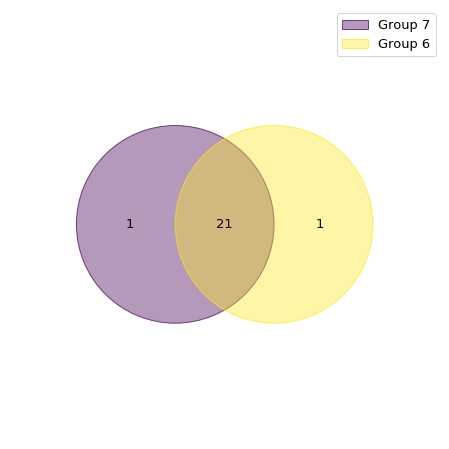

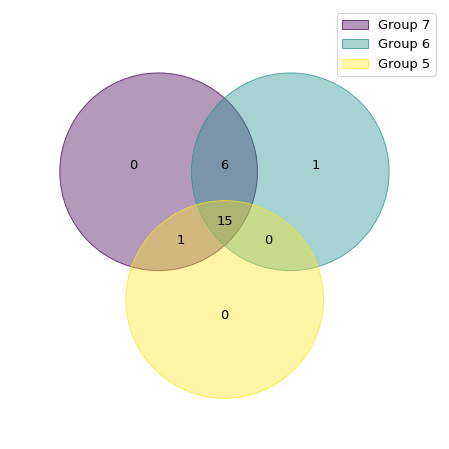

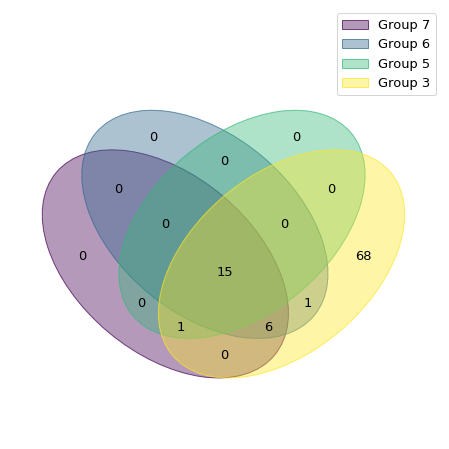

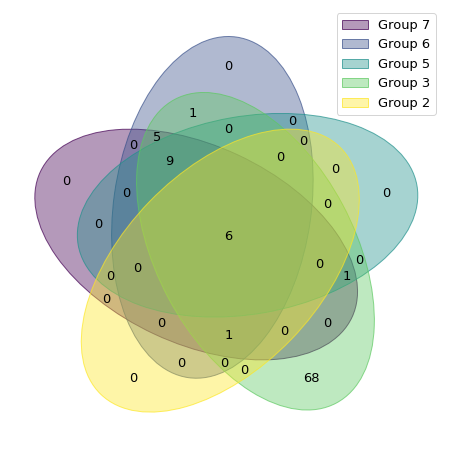

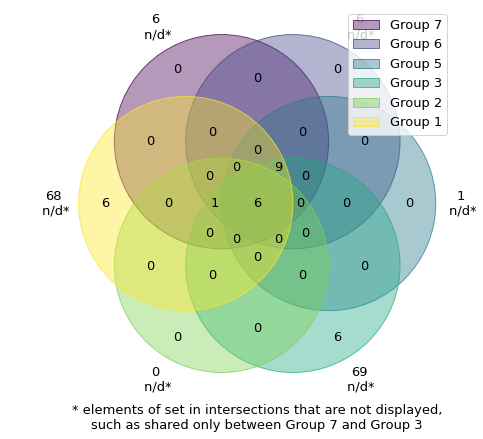

In [60]:

def predict_groups_preferences(users_in_groups, unique_submissions:dict, train_data, group_centers=None, user_grouping_method = "rep", existing_votes = None, existing_user_updown_votes=None):
    # users_in_groups = existing_user_votes.most_common(3)
    groups_users_preferred_submissions = {}
    used_group_centers = []
    if os.path.exists(config["preferred_submissions_venn_figure_dir"]):
        shutil.rmtree(config["preferred_submissions_venn_figure_dir"])
    os.makedirs(config["preferred_submissions_venn_figure_dir"], exist_ok=True)
    for group_x in users_in_groups:
        if (user_grouping_method == "rep") and (len(users_in_groups[group_x]) <= config["group_user_num_lower_thres"] or len(users_in_groups[group_x]) > config["group_user_num_upper_thres"]): # keep middle sized centers
            continue
        if group_centers is not None: # only keep not similar centers
            group_x_center = group_centers[group_x]
            similar_center = False
            for center in used_group_centers:
                if torch.dot(group_x_center, center) > 0:
                    similar_center = True
                    break
            if similar_center:
                continue

        ################ predicting votes of some users and some submissions ##################
        group_x_users_subreddit_submissions_data = convert_group_users_subreddit_submissions_data(users_in_groups[group_x], unique_submissions)
        predicted_group_x_users_submissions_votes = predict_group_users_submissions_votes(model, group_x_users_subreddit_submissions_data)
        group_x_users_preferred_submissions, group_x_preferred_submissions_ranking, group_x_users_submission_votes, group_x_users_confidence, pred_group_x_users_subreddit_submission_vote_score_matrix, pred_group_x_users_subreddit_submission_vote_matrix = get_group_users_preferred_submissions(model, predicted_group_x_users_submissions_votes, users_in_groups[group_x], group_x_users_subreddit_submissions_data, train_data, existing_votes, thres = config["upvote_downvote_ratio_thres"], existing_pred_submission_user_vote_score_matrix = pred_all_submission_user_vote_score_matrix) # can delete existing_pred_submission_user_vote_score_matrix if not available

        ##########################################################################################

        groups_users_preferred_submissions[f"Group {group_x}"] = group_x_users_preferred_submissions
        if user_grouping_method == "single_user_as_group":
            user_train_vote_prompt = f"voted {existing_user_updown_votes[list(users_in_groups[group_x])[0]]} in training data, prediction confidence {list(group_x_users_confidence.values())[0]}, "
        else:
            user_train_vote_prompt = ""
        print_log(config["log_path"], f"Users in group {group_x} {user_train_vote_prompt}prefers {len(group_x_users_preferred_submissions)}/{len(unique_submissions)} submissions (sorted using %upvotes): {group_x_preferred_submissions_ranking[:len(group_x_users_preferred_submissions)]}")
        if len(groups_users_preferred_submissions) > 1 and len(groups_users_preferred_submissions) <=6:
            ax = venn(groups_users_preferred_submissions) if len(groups_users_preferred_submissions) <=5 else pseudovenn(groups_users_preferred_submissions)
            ax.figure.savefig(f"{config['preferred_submissions_venn_figure_dir']}/{len(groups_users_preferred_submissions)}_groups.png")


model = model.to(model.device)
predict_groups_preferences(users_in_groups, subreddit_test_submissions[a_subreddit], train_data, group_centers, user_grouping_method=user_grouping_method, existing_votes=existing_votes, existing_user_updown_votes=existing_user_updown_votes)
